<a href="https://colab.research.google.com/github/Theseyh/Big-Data-Framework/blob/main/Rendu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import os

os.environ["SPARK_VERSION"] = "spark-3.5.3"
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget  http://apache.osuosl.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!echo $SPARK_VERSION-bin-hadoop3.tgz
!rm $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,513 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,736 kB]
Fetched 4,504 kB in 2s (2,554 kB/s)
Reading package lists... Done
W: Skipping acquire of configur

### Set Environment Variables
Set the locations where Spark and Java are installed.

In [49]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark/"
os.environ["DRIVE_DATA"] = "/content/gdrive/My Drive/Big Data Framework/data/"

!rm /content/spark
!ln -s /content/$SPARK_VERSION-bin-hadoop3 /content/spark
!export PATH=$PATH:$SPARK_HOME/bin:$SPARK_HOME/sbin
!echo $SPARK_HOME
!env |grep  "DRIVE_DATA"

/content/spark/
DRIVE_DATA=/content/gdrive/My Drive/Big Data Framework/data/


### Start a SparkSession
This will start a local Spark session.

In [50]:
!python -V

import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext.getOrCreate()

# Example: shows the PySpark version
print("PySpark version {0}".format(sc.version))

# Example: parallelise an array and show the 2 first elements
sc.parallelize([2, 3, 4, 5, 6]).cache().take(2)

Python 3.10.12
PySpark version 3.5.3


[2, 3]

In [51]:
from pyspark.sql import SparkSession
# We create a SparkSession object (or we retrieve it if it is already created)
spark = SparkSession \
.builder \
.appName("My application") \
.config("spark.some.config.option", "some-value") \
.master("local[4]") \
.getOrCreate()
# We get the SparkContext
sc = spark.sparkContext

## Exercise 3.1: Word count

Count the number of words *per line* in the $DRIVE_DATA/quijote.txt file.

Repeat the exercise but this time counting the number of words *in the whole file*.

In [52]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [53]:
!head "$DRIVE_DATA/quijote.txt"

﻿The Project Gutenberg EBook of Don Quijote, by Miguel de Cervantes Saavedra

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.net


Title: Don Quijote



In [54]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Initialize Spark session
spark = SparkSession.builder.appName("WordCount").getOrCreate()

# Define file path
file_path = "/content/gdrive/My Drive/Big Data Framework/data/quijote.txt"

# Load the file into a DataFrame, with one line per row
lines_df = spark.read.text(file_path)

# Count words per line
words_per_line_df = lines_df.withColumn("word_count", F.size(F.split(F.col("value"), " ")))

# Show the word counts per line
words_per_line_df.show(truncate=False)

# Count total words in the whole file
total_words = words_per_line_df.select(F.sum("word_count").alias("total_word_count")).collect()[0]["total_word_count"]

print(f"Total number of words in the file: {total_words}")

# Stop the Spark session
spark.stop()


+---------------------------------------------------------------------------+----------+
|value                                                                      |word_count|
+---------------------------------------------------------------------------+----------+
|The Project Gutenberg EBook of Don Quijote, by Miguel de Cervantes Saavedra|12        |
|                                                                           |1         |
|This eBook is for the use of anyone anywhere at no cost and with           |14        |
|almost no restrictions whatsoever.  You may copy it, give it away or       |13        |
|re-use it under the terms of the Project Gutenberg License included        |11        |
|with this eBook or online at www.gutenberg.net                             |7         |
|                                                                           |1         |
|                                                                           |1         |
|Title: Don Quijote  

V2


In [55]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Initialize Spark session
spark = SparkSession.builder.appName("WordCount").getOrCreate()

# Define file path
file_path = "/content/gdrive/My Drive/Big Data Framework/data/quijote.txt"

# Load the file into a DataFrame, with one line per row
lines_df = spark.read.text(file_path)

# Filter out empty lines (lines that are empty or only contain whitespace)
non_empty_lines_df = lines_df.filter(F.trim(F.col("value")) != "")

# Count words per line
words_per_line_df = non_empty_lines_df.withColumn("word_count", F.size(F.split(F.col("value"), " ")))

# Show the word counts per line
words_per_line_df.show(truncate=False)

# Count total words in the whole file
total_words = words_per_line_df.select(F.sum("word_count").alias("total_word_count")).collect()[0]["total_word_count"]

print(f"Total number of words in the file: {total_words}")

# Stop the Spark session
spark.stop()


+---------------------------------------------------------------------------+----------+
|value                                                                      |word_count|
+---------------------------------------------------------------------------+----------+
|The Project Gutenberg EBook of Don Quijote, by Miguel de Cervantes Saavedra|12        |
|This eBook is for the use of anyone anywhere at no cost and with           |14        |
|almost no restrictions whatsoever.  You may copy it, give it away or       |13        |
|re-use it under the terms of the Project Gutenberg License included        |11        |
|with this eBook or online at www.gutenberg.net                             |7         |
|Title: Don Quijote                                                         |3         |
|Author: Miguel de Cervantes Saavedra                                       |5         |
|Posting Date: April 27, 2010 [EBook #2000]                                 |7         |
|Release Date: Decemb

V3

In [56]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Initialize Spark session
spark = SparkSession.builder.appName("WordCount").getOrCreate()

# Define file path
file_path = "/content/gdrive/My Drive/Big Data Framework/data/quijote.txt"

# Load the file into a DataFrame, with one line per row
lines_df = spark.read.text(file_path)

# Filter out empty lines (lines that are empty or only contain whitespace)
non_empty_lines_df = lines_df.filter(F.trim(F.col("value")) != "")

# Count words per line
words_per_line_df = non_empty_lines_df.withColumn("word_count", F.size(F.split(F.col("value"), "\s+")))

# Show the word counts per line
words_per_line_df.show(truncate=False)

# Count total words in the whole file
total_words = words_per_line_df.select(F.sum("word_count").alias("total_word_count")).collect()[0]["total_word_count"]

print(f"Total number of words in the file: {total_words}")

# Stop the Spark session
spark.stop()


+---------------------------------------------------------------------------+----------+
|value                                                                      |word_count|
+---------------------------------------------------------------------------+----------+
|The Project Gutenberg EBook of Don Quijote, by Miguel de Cervantes Saavedra|12        |
|This eBook is for the use of anyone anywhere at no cost and with           |14        |
|almost no restrictions whatsoever.  You may copy it, give it away or       |12        |
|re-use it under the terms of the Project Gutenberg License included        |11        |
|with this eBook or online at www.gutenberg.net                             |7         |
|Title: Don Quijote                                                         |3         |
|Author: Miguel de Cervantes Saavedra                                       |5         |
|Posting Date: April 27, 2010 [EBook #2000]                                 |7         |
|Release Date: Decemb

## Exercise 4.1: Pi Estimation

Using the Monte Carlo method, estimate the value of Pi. Use the random() method from the random class.

In [57]:
from pyspark.sql import SparkSession
import random

# Initialize Spark session
spark = SparkSession.builder.appName("MonteCarloPi").getOrCreate()

# Number of random points to generate
NUM_SAMPLES = 10_000_000

# Function to generate a random point and check if it's inside the unit circle
def is_point_inside_unit_circle(_):
    x = random.uniform(-1, 1)
    y = random.uniform(-1, 1)
    return 1 if x**2 + y**2 <= 1 else 0

# Parallelize the calculation across Spark workers
rdd = spark.sparkContext.parallelize(range(NUM_SAMPLES))
points_inside_circle = rdd.map(is_point_inside_unit_circle).reduce(lambda a, b: a + b)

# Approximate π
pi_estimate = (4 * points_inside_circle) / NUM_SAMPLES

print(f"Estimated value of π: {pi_estimate}")




Estimated value of π: 3.1424188


## Exercise 4.2: Inspect a log file

Upload the file /var/log/syslog from your computer to this notebook. Then, select only the "bad lines": WARNING and ERROR messages.

In [58]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Initialize Spark session
spark = SparkSession.builder.appName("SyslogFilter").getOrCreate()

# Load the syslog file into a DataFrame
#file_path = "/content/syslog"  # Adjust path if necessary after upload
#syslog_df = spark.read.text(file_path)

syslog_df = spark.read.text(os.environ["DRIVE_DATA"] + "/syslog")

# Filter lines containing WARNING or ERROR
bad_lines_df = syslog_df.filter(
    F.col("value").contains("WARNING") | F.col("value").contains("ERROR")
)

# Show the filtered "bad lines"
bad_lines_df.show(truncate=False)



+-------------------------------------------------------------------------------------------------+
|value                                                                                            |
+-------------------------------------------------------------------------------------------------+
|Nov 26 00:01:13 student-laptop ovpn-cytech.students[1260]: WARNING: Your certificate has expired!|
|Nov 26 00:12:13 student-laptop ovpn-cytech.students[1260]: WARNING: Your certificate has expired!|
|Nov 26 00:23:14 student-laptop ovpn-cytech.students[1260]: WARNING: Your certificate has expired!|
|Nov 26 00:34:14 student-laptop ovpn-cytech.students[1260]: WARNING: Your certificate has expired!|
|Nov 26 00:45:14 student-laptop ovpn-cytech.students[1260]: WARNING: Your certificate has expired!|
|Nov 26 00:56:14 student-laptop ovpn-cytech.students[1260]: WARNING: Your certificate has expired!|
|Nov 26 01:07:15 student-laptop ovpn-cytech.students[1260]: WARNING: Your certificate has expired!|


### Exercise 5.1: Word count

**Using RDDs**, count the number of lines in the `$DRIVE_DATA/quijote.txt` file. Then, count the number of words in the file. Finally, count the number of *different* words in the file.


In [60]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

# Load the text file into an RDD
lines = sc.textFile(os.environ["DRIVE_DATA"] + "/quijote.txt")

# Count the number of lines
num_lines = lines.count()
print(f"Number of lines: {num_lines}")

# Count the number of words
words = lines.flatMap(lambda line: line.split())
num_words = words.count()
print(f"Number of words: {num_words}")

# Count the number of different words
distinct_words = words.distinct()
num_distinct_words = distinct_words.count()
print(f"Number of distinct words: {num_distinct_words}")

Number of lines: 37861
Number of words: 384260
Number of distinct words: 40059


### Exercise 5.2: Count people by age

Using RDDs, create a barplot showing of number of people (y-axis) per age (x-axis) using the information in the $DRIVE_DATA/people.txt file



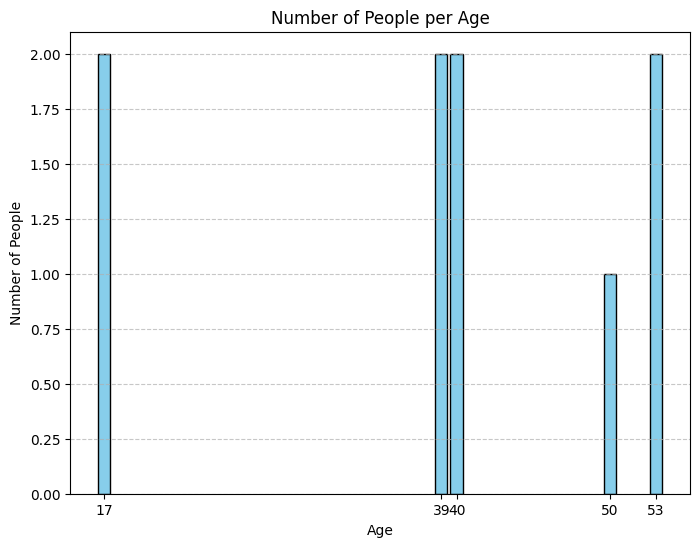

In [61]:
from pyspark import SparkContext
import matplotlib.pyplot as plt
import os  # Import the os module for environment variable expansion


# Define file path using os.environ to expand the environment variable
file_path = os.path.join(os.environ["DRIVE_DATA"], "people.txt")

# Load data into an RDD
data_rdd = sc.textFile(file_path)

# Parse the data: split by tab and map each line to (age, 1)
age_count_rdd = (
    data_rdd
    .map(lambda line: line.split("\t")[1])  # Extract age
    .map(lambda age: (int(age), 1))        # Convert age to integer and map to (age, 1)
    .reduceByKey(lambda a, b: a + b)       # Aggregate counts by age
)

# Collect results
age_count = age_count_rdd.collect()

# Separate keys and values for plotting
ages, counts = zip(*sorted(age_count))  # Sort by age for a clean plot

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(ages, counts, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.title('Number of People per Age')
plt.xticks(ages)  # Ensure all ages are shown as x-axis ticks
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Exercise 5.3: Obtain the number of received citations

Using RDDs, write a PySpark program that obtains, from the cite75_99.txt file, the number of citations received by each patent.


In [ ]:
from pyspark import SparkContext
import os

# Load the data into an RDD
data_rdd = sc.textFile((os.environ["DRIVE_DATA"] + "/cite75_99.txt")
)

# Remove the header line
header = data_rdd.first()
data_rdd = data_rdd.filter(lambda line: line != header)

# Parse the data: split each line by comma and extract the "CITED" column
cited_rdd = (
    data_rdd
    .map(lambda line: line.split(","))  # Split by comma
    .map(lambda fields: (fields[1], 1))  # Map "CITED" patent to (CITED, 1)
    .reduceByKey(lambda a, b: a + b)  # Count occurrences of each "CITED" patent
)

# Collect the results
cited_counts = cited_rdd.collect()

# Print the results
for cited, count in cited_counts:
    print(f"Patent {cited} received {count} citations.")

Streaming output truncated to the last 5000 lines.
Patent 4641980 received 26 citations.
Patent 4107112 received 6 citations.
Patent 4680234 received 13 citations.
Patent 1073873 received 1 citations.
Patent 4678382 received 1 citations.
Patent 3972510 received 2 citations.
Patent 4636140 received 1 citations.
Patent 3182816 received 2 citations.
Patent 4353678 received 2 citations.
Patent 4498841 received 1 citations.
Patent 4586867 received 22 citations.
Patent 3300122 received 2 citations.
Patent 4648847 received 1 citations.
Patent 4652213 received 10 citations.
Patent 1325398 received 1 citations.
Patent 2297554 received 1 citations.
Patent 2673602 received 1 citations.
Patent 2712819 received 1 citations.
Patent 4310301 received 3 citations.
Patent 981430 received 4 citations.
Patent 4531915 received 29 citations.
Patent 3383641 received 1 citations.
Patent 4519661 received 4 citations.
Patent 2791755 received 5 citations.
Patent 4235183 received 4 citations.
Patent 4522001 recei